In [1]:
# Imports

from collections import defaultdict

# pandas
import pandas as pd
from pandas import Series,DataFrame
pd.options.display.max_colwidth=100
    
from IPython.display import display

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectPercentile, SelectFromModel

In [2]:
# read the test and train samples in a csv

train = pd.read_csv("train.csv",index_col='Id')
test  = pd.read_csv("test.csv",index_col='Id')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 1 to 15120
Data columns (total 55 columns):
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_Type1                            15120 non-null int64
Soil_T

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565892 entries, 15121 to 581012
Data columns (total 54 columns):
Elevation                             565892 non-null int64
Aspect                                565892 non-null int64
Slope                                 565892 non-null int64
Horizontal_Distance_To_Hydrology      565892 non-null int64
Vertical_Distance_To_Hydrology        565892 non-null int64
Horizontal_Distance_To_Roadways       565892 non-null int64
Hillshade_9am                         565892 non-null int64
Hillshade_Noon                        565892 non-null int64
Hillshade_3pm                         565892 non-null int64
Horizontal_Distance_To_Fire_Points    565892 non-null int64
Wilderness_Area1                      565892 non-null int64
Wilderness_Area2                      565892 non-null int64
Wilderness_Area3                      565892 non-null int64
Wilderness_Area4                      565892 non-null int64
Soil_Type1                            565892 

In [5]:
# no nans test and train, that's nice
# a look at correlations

train_corr=train.corr()


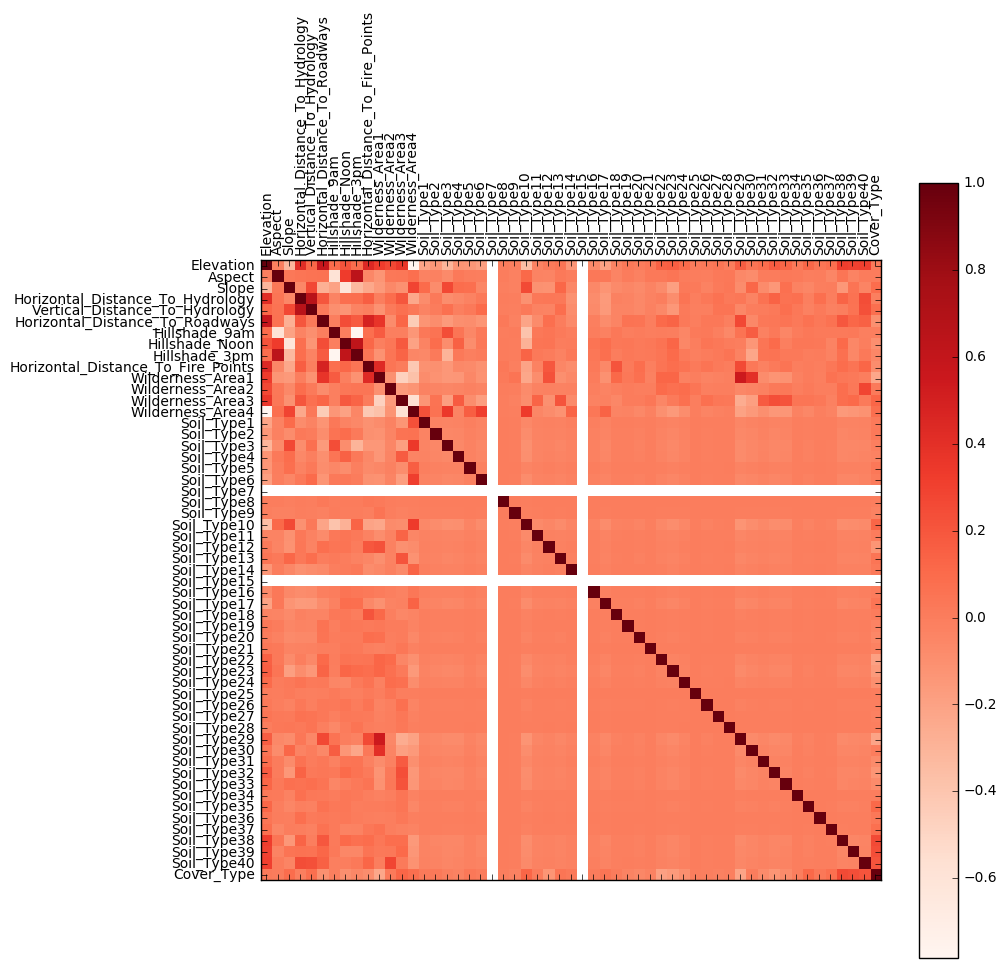

In [6]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # to have ticks at every bin


f,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.matshow(train_corr,cmap='Reds')
ax.set_xticklabels(['']+list(train.columns),rotation='vertical')
ax.set_yticklabels(['']+list(train.columns))
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
f.colorbar(im)

In [7]:
# Soil_Type7 and 15 are strange

print "Soil_Type7 train",train['Soil_Type7'].value_counts(dropna=False)
print "Soil_Type15 train",train['Soil_Type15'].value_counts(dropna=False)

print "Soil_Type7 test",test['Soil_Type7'].value_counts(dropna=False)
print "Soil_Type15 test",test['Soil_Type15'].value_counts(dropna=False)

# ok, the issue is that these two soil types are very rare.
# They are completely absent from the training, and only appear in a small fraction of the test
# since I don't have them in the training test, the cleanest thing is very likely to just drop them


Soil_Type7 train 0    15120
Name: Soil_Type7, dtype: int64
Soil_Type15 train 0    15120
Name: Soil_Type15, dtype: int64
Soil_Type7 test 0    565787
1       105
Name: Soil_Type7, dtype: int64
Soil_Type15 test 0    565889
1         3
Name: Soil_Type15, dtype: int64


In [8]:

# try to reverse the onehotencoding

col_list1=[x for x in train.columns if 'Soil_Type' in x]
col_list2=[x for x in train.columns if 'Wilderness' in x]

soiltype_no_ohe=train[col_list1].idxmax(axis=1)
wilderness_no_ohe=train[col_list2].idxmax(axis=1)

# this turns the types to ints
soiltype_no_ohe=soiltype_no_ohe.str[9:].astype(np.dtype(int))
wilderness_no_ohe=wilderness_no_ohe.str[-1:].astype(np.dtype(int))

#print soiltype_no_ohe.head()
#print wilderness_no_ohe.head()

# create new dataset

train_no_ohe=train.drop(col_list1+col_list2,axis=1)
train_no_ohe['Soil_Type']=soiltype_no_ohe
train_no_ohe['Wilderness_area']=wilderness_no_ohe
print train_no_ohe.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 1 to 15120
Data columns (total 13 columns):
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Cover_Type                            15120 non-null int64
Soil_Type                             15120 non-null int64
Wilderness_area                       15120 non-null int64
dtypes: int64(13)
memory usage: 1.6 MB
None


In [9]:
# repeat manipulation for test dataset
# try to reverse the onehotencoding

col_list1=[x for x in test.columns if 'Soil_Type' in x]
col_list2=[x for x in test.columns if 'Wilderness' in x]

soiltype_no_ohe=test[col_list1].idxmax(axis=1)
wilderness_no_ohe=test[col_list2].idxmax(axis=1)

# this turns the types to ints
soiltype_no_ohe=soiltype_no_ohe.str[9:].astype(np.dtype(int))
wilderness_no_ohe=wilderness_no_ohe.str[-1:].astype(np.dtype(int))

#print soiltype_no_ohe.head()
#print wilderness_no_ohe.head()

# create new dataset

test_no_ohe=test.drop(col_list1+col_list2,axis=1)
test_no_ohe['Soil_Type']=soiltype_no_ohe
test_no_ohe['Wilderness_area']=wilderness_no_ohe
print test_no_ohe.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 565892 entries, 15121 to 581012
Data columns (total 12 columns):
Elevation                             565892 non-null int64
Aspect                                565892 non-null int64
Slope                                 565892 non-null int64
Horizontal_Distance_To_Hydrology      565892 non-null int64
Vertical_Distance_To_Hydrology        565892 non-null int64
Horizontal_Distance_To_Roadways       565892 non-null int64
Hillshade_9am                         565892 non-null int64
Hillshade_Noon                        565892 non-null int64
Hillshade_3pm                         565892 non-null int64
Horizontal_Distance_To_Fire_Points    565892 non-null int64
Soil_Type                             565892 non-null int64
Wilderness_area                       565892 non-null int64
dtypes: int64(12)
memory usage: 56.1 MB
None


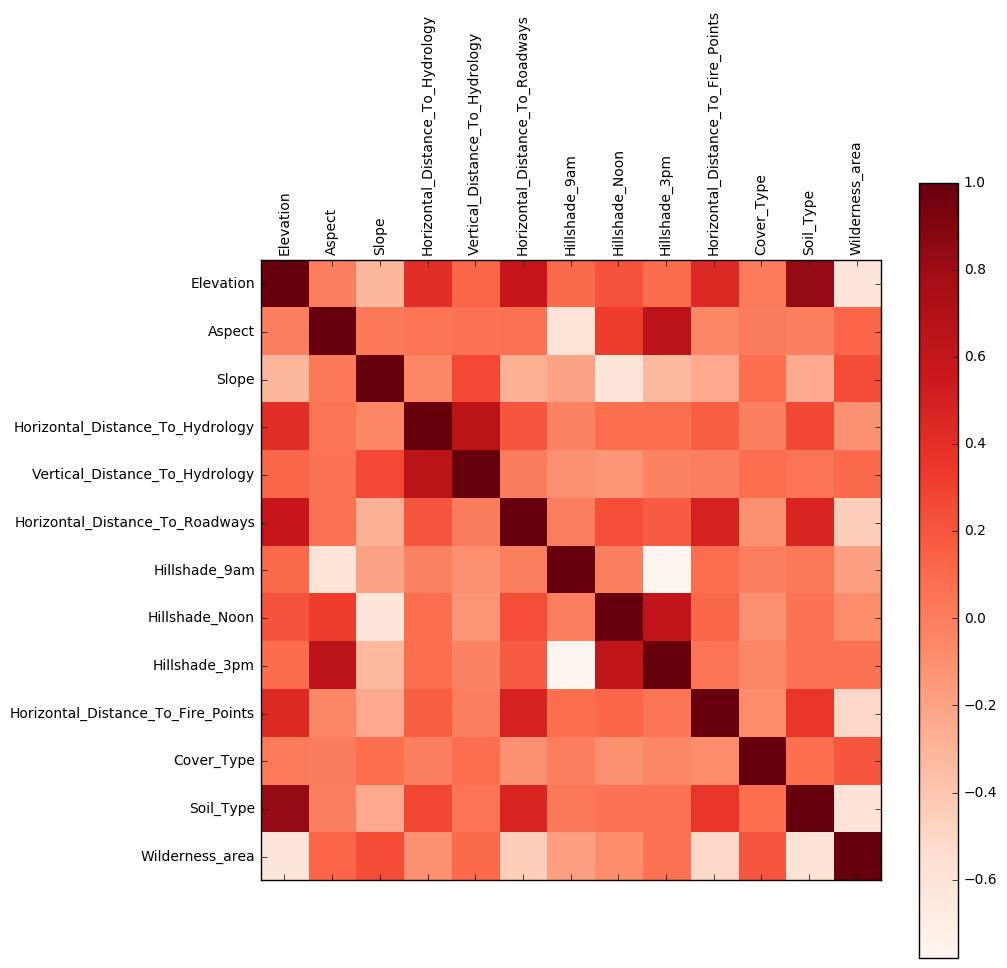

In [10]:
# plot again correlations

f,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.matshow(train_no_ohe.corr(),cmap='Reds')
ax.set_xticklabels([''] + list(train_no_ohe.columns),rotation='vertical')
ax.set_yticklabels( [''] + list(train_no_ohe.columns))
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
f.colorbar(im)


In [11]:
# create inputs for classification

Xtrain=train.drop(['Soil_Type7','Soil_Type15','Cover_Type'],axis=1).values
Ytrain=train.Cover_Type.values

Xtrain_no_ohe=train_no_ohe.drop(['Cover_Type'],axis=1).values

In [12]:
# repeat for test set
Xtest=test.drop(['Soil_Type7','Soil_Type15'],axis=1).values
Xtest_no_ohe=test_no_ohe.values

In [13]:
# we will run a few tests, and store here the results
# key will be a descriptive string, value is list [score, best_params,best_estimator]

ml_results=defaultdict(list)

In [16]:
# let's start easy, with a LogisticRegression classifier. Parameters chosen with GridSearchCV

# prepare a pipeline with scaler+model

pipe_logreg=Pipeline([('scaler',MinMaxScaler()),('logreg',LogisticRegression())])

# use gridsearch

grid_logreg={
    'logreg__C':[0.01,0.1,1.0,10],
    'logreg__multi_class':['ovr', 'multinomial'],
    'logreg__solver':['newton-cg','lbfgs','sag']
}


gsearch_logreg=GridSearchCV(pipe_logreg,grid_logreg,cv=5)

dict_inputs={"plain":Xtrain,
            "no_ohe":Xtrain_no_ohe}

for name,features in dict_inputs.iteritems():
    
    gsearch_logreg.fit(features,Ytrain)
    results_logreg=pd.DataFrame(gsearch_logreg.cv_results_)
    print "validation score logreg",name,gsearch_logreg.best_score_
    ml_results['LogReg '+name]=[gsearch_logreg.best_score_,gsearch_logreg.best_params_,gsearch_logreg.best_estimator_]

 validation score logreg plain 0.641931216931
validation score logreg no_ohe 0.638029100529


In [17]:
# add percentile feature selection
pipe_logreg_feat=Pipeline([('scaler',MinMaxScaler()),
                           ('selection',SelectPercentile(percentile=50)),
                           ('logreg',LogisticRegression())])


gsearch_logreg_feat=GridSearchCV(pipe_logreg_feat,grid_logreg,cv=5)


for name,features in dict_inputs.iteritems():
    
    gsearch_logreg_feat.fit(features,Ytrain)
    results_logreg_feat=pd.DataFrame(gsearch_logreg_feat.cv_results_)
    print "training score logreg_feat",name,gsearch_logreg_feat.best_score_
    ml_results['LogReg, Feat '+name]=[gsearch_logreg_feat.best_score_,gsearch_logreg_feat.best_params_,gsearch_logreg_feat.best_estimator_]



training score logreg_feat plain 0.63373015873
training score logreg_feat no_ohe 0.612962962963


In [18]:
# add feature selection with random forest


pipe_logreg_feat2=Pipeline([('scaler',MinMaxScaler()),
                            ('selection',SelectFromModel(RandomForestClassifier(n_estimators=50), threshold='median')),
                            ('logreg',LogisticRegression())])
gsearch_logreg_feat2=GridSearchCV(pipe_logreg_feat2,grid_logreg,cv=5)


for name,features in dict_inputs.iteritems():
    
    gsearch_logreg_feat2.fit(features,Ytrain)
    results_logreg_feat2=pd.DataFrame(gsearch_logreg_feat2.cv_results_)
    print "training score logreg_feat2",name,gsearch_logreg_feat2.best_score_
    ml_results['LogReg, Feat2 '+name]=[gsearch_logreg_feat2.best_score_,gsearch_logreg_feat2.best_params_,gsearch_logreg_feat2.best_estimator_]


training score logreg_feat2 plain 0.638822751323
training score logreg_feat2 no_ohe 0.605621693122


In [19]:
# try a random forest classifier, without feature selection

# now let's try a random forest
pipe_forest=Pipeline([('scaler',MinMaxScaler()),('forest',RandomForestClassifier())])

grid_forest={
    'forest__n_estimators':[10,20,50,70,100,200],
    'forest__min_samples_split':[2,4,6,12,18,24],
}

gsearch_forest=GridSearchCV(pipe_forest,grid_forest,cv=5)

for name,features in dict_inputs.iteritems():
    
    gsearch_forest.fit(features,Ytrain)
    results_forest=pd.DataFrame(gsearch_forest.cv_results_)
    print "training score forest",name,gsearch_forest.best_score_
    ml_results['RandomForest '+name]=[gsearch_forest.best_score_,gsearch_forest.best_params_,gsearch_forest.best_estimator_]


training score forest plain 0.78458994709
training score forest no_ohe 0.78835978836


In [27]:
# add an SVC
pipe_svc=Pipeline([('scaler',MinMaxScaler()),('svc',SVC())])

grid_svc = [{'svc__kernel': ['rbf'], 'svc__C': [0.001,0.01,0.1,1,10,100], 'svc__gamma':[0.001,0.01,0.1,1,10,100]},
            {'svc__kernel': ['linear'],'svc__C': [0.001,0.01,0.1,1,10,100],}]

gsearch_svc=GridSearchCV(pipe_forest,grid_forest,cv=5)

for name,features in dict_inputs.iteritems():
    
    gsearch_svc.fit(features,Ytrain)
    print "training score svc",name,gsearch_svc.best_score_
    ml_results['SVC '+name]=[gsearch_svc.best_score_,gsearch_svc.best_params_,gsearch_svc.best_estimator_]

training score svc plain 0.783201058201
training score svc no_ohe 0.788756613757


In [35]:
# print out the results of the searches, with scores on the validation data
# conversion to DataFrame is not needed, but gives nicer display

scores=[(x,y[0],y[2]) for x,y in ml_results.items()]
scores_df=pd.DataFrame.from_records(scores,columns=['configuration','validation score','estimator'])
scores_df.set_index('configuration',inplace=True)
scores_df_sorted=scores_df.sort_values('validation score', ascending=False)
display(scores_df_sorted[['validation score']])

,validation score,estimator
configuration,,
SVC no_ohe,0.788757,"Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('forest', RandomFore..."
RandomForest no_ohe,0.788360,"Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('forest', RandomFore..."
RandomForest plain,0.784590,"Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('forest', RandomFore..."
SVC plain,0.783201,"Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('forest', RandomFore..."
LogReg plain,0.641931,"Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('logreg', LogisticRe..."
"LogReg, Feat2 plain",0.638823,"Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectF..."
LogReg no_ohe,0.638029,"Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('logreg', LogisticRe..."
"LogReg, Feat plain",0.633730,"Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectP..."
"LogReg, Feat no_ohe",0.612963,"Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selection', SelectP..."


In [42]:
prediction=scores_df_sorted.ix[0,'estimator'].predict(Xtest_no_ohe)

In [46]:
test_no_ohe['prediction']=prediction
test_no_ohe.head()


In [49]:
test_no_ohe.to_csv('submission.csv',columns=)
